In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

#loading data
file_1="/workspaces/State-of-Health-Estimation-Battery/Dataset/B0005_dis_dataset.csv"
dataset=pd.read_csv(file_1)

In [2]:
Soh=dataset["capacity"]/2
time=dataset[["time"]]

In [3]:
# normalising data
dataset=dataset[["cycle","capacity","voltage_measured","current_measured","temperature_measured","current_load","voltage_load"]]
df_norm = (dataset-dataset.min())/(dataset.max()-dataset.min())
df_norm["time"]=time
df_norm["Soh"]=Soh

In [4]:
att_=["cycle","capacity","voltage_measured","current_measured","temperature_measured","current_load","voltage_load","time"]
att=["cycle","current_load","current_measured"]
X_axis="cycle"

In [5]:
X = df_norm[att]
Y = df_norm[["Soh"]]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0) 

In [7]:
#sorting data wrt to index
X_test = X_test.sort_index(axis=0)
X_train= X_train.sort_index(axis=0)
y_train= y_train.sort_index(axis=0)
y_test = y_test.sort_index(axis=0)

In [8]:
#making models
regressor1 = RandomForestRegressor(n_estimators=100,random_state=0)
regressor1.fit(X_train,y_train.values.ravel())
y_pred_1= regressor1.predict(X_test)

In [9]:
regressor2 = RandomForestRegressor(n_estimators=50,random_state=0)
regressor2.fit(X_train,y_train.values.ravel())            
y_pred_2= regressor2.predict(X_test)

In [10]:
regressor3 = RandomForestRegressor(n_estimators=30,random_state=0)
regressor3.fit(X_train,y_train.values.ravel())
y_pred_3= regressor3.predict(X_test)

In [11]:
def graph_plot(b,a,model):
    plt.plot(X_test[b],y_test,color='red',label='actual',linewidth=4)
    plt.plot(X_test[b],a,color='cyan',label='Node_'+model,linewidth=1)
    plt.xlabel("cycle")
    plt.ylabel("SOH")
    rmse="Rmse = "+str(np.sqrt(metrics.mean_squared_error(y_test, a)))
    plt.figtext(0.33, -0.03, rmse, fontsize=10)
    plt.legend(loc="upper right")
    plt.suptitle("random forest regressor node:"+model)
    plt.show()
    print(np.sqrt(metrics.mean_squared_error(y_test, a)))

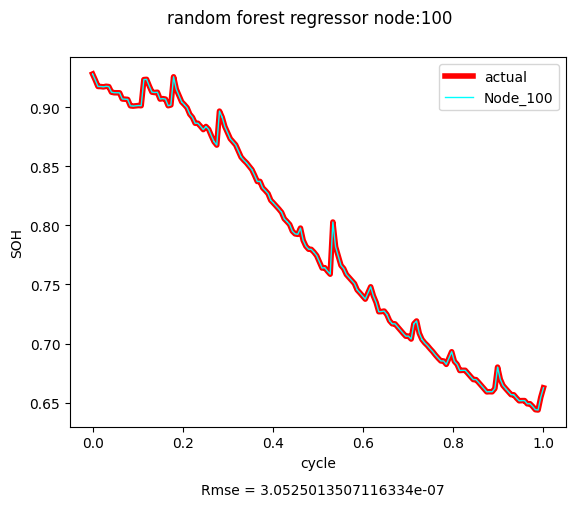

3.0525013507116334e-07


In [12]:
graph_plot(X_axis,y_pred_1,"100")#3.05250135069885e-07

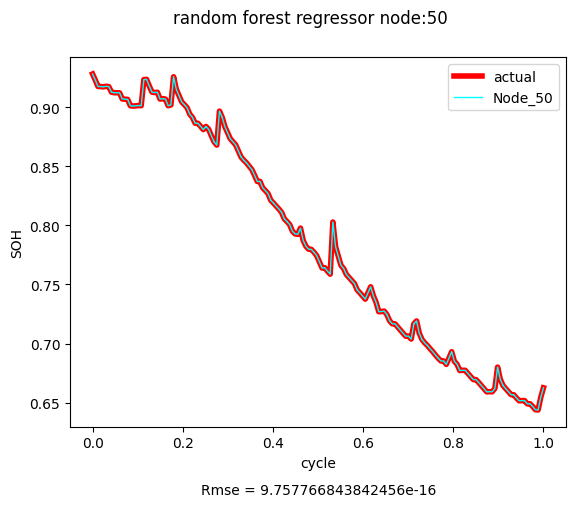

9.757766843842456e-16


In [13]:
graph_plot(X_axis,y_pred_2,"50")#9.70500226793594e-16

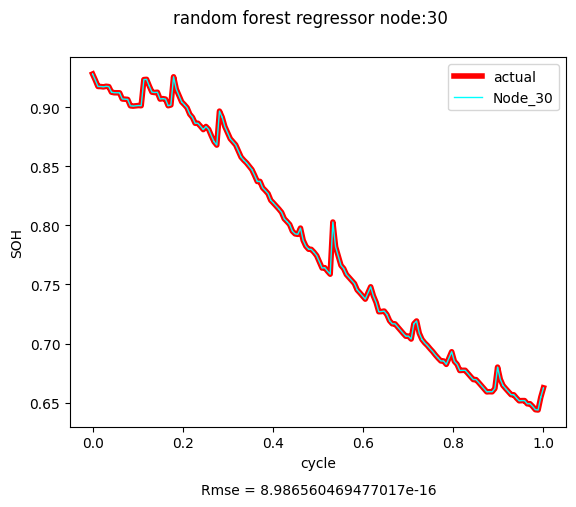

8.986560469477017e-16


In [14]:
graph_plot(X_axis,y_pred_3,"30")#8.933219312798214e-16